# Meta label metric

Testing different base model evaluation performance metric (used as meta label)

- precision
- recall
- auc
- kappa
- f1

In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestClassifier
import lightgbm as ltb

# Custom classes
import sys
sys.path.insert(0,'..')
from meta_learning import MetaLearner, evaluator, Model
from utils import plot_results, offline_train

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Macros

In [2]:
# Macros

CLASS_COL = 'class'

OFFLINE_PHASE_SIZE = 10000
BASE_TRAIN_SIZE = 7000
META_TRAIN_SIZE = 0.5
R_STATE = 123

ETA = 100  # Window size used to extract meta features
STEP = 30  # Step for next meta learning iteration
KNOWN_TARGET_WINDOW_SIZE = 0  # Target is unknown

## Read data

In [3]:
f = open("../datasets/real/elec.arff", "r")
data, meta = arff.loadarff(f)

df = pd.DataFrame(data)
df['weekday'] = pd.to_numeric(df['day'])
df['class'] = df['class'].str.decode("utf-8")
df = df.drop(['date', 'period', 'day'], axis=1)

print(df.shape)
df.head()

(45312, 7)


,nswprice,nswdemand,vicprice,vicdemand,transfer,class,weekday
0,0.056443,0.439155,0.003467,0.422915,0.414912,UP,2
1,0.051699,0.415055,0.003467,0.422915,0.414912,UP,2
2,0.051489,0.385004,0.003467,0.422915,0.414912,UP,2
3,0.045485,0.314639,0.003467,0.422915,0.414912,UP,2
4,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,2


In [4]:
n = df.shape[0]
class_weight = df['class'].value_counts().apply(lambda x: x/n).to_dict()
class_weight

{'DOWN': 0.5754546257062146, 'UP': 0.4245453742937853}

In [5]:
offline_df = df.iloc[:OFFLINE_PHASE_SIZE]
online_df = df.iloc[OFFLINE_PHASE_SIZE:]
validation_df = online_df.iloc[:int(OFFLINE_PHASE_SIZE*META_TRAIN_SIZE)]

## Fase offline

In [6]:
base_model = Model(basis_model=RandomForestClassifier, hyperparameters={"max_depth": 6, "warm_start": True, "min_samples_split": 0.05})
meta_model = Model(basis_model=ltb.LGBMRegressor, hyperparameters={"num_leaves": 21, "max_depth": 5})

learner = MetaLearner(
    base_model=base_model,
    meta_model=meta_model,
    base_model_class_column=CLASS_COL,
    eta=ETA,
    step=STEP,
    known_target_window_size=KNOWN_TARGET_WINDOW_SIZE,
    )

learner.offline_stage(offline_df)

# Experiments

In [7]:
validation_base = learner._get_offline_metabase(validation_df)
results = []

In [8]:
# BASELINE

for metric in evaluator.clf_metrics:
    y_true = learner.meta_base[metric]
    y_pred = [np.mean(y_true)] * len(y_true)
    r2 = evaluator.evaluate(y_true, y_pred, 'r2')
    mse = evaluator.evaluate(y_true, y_pred, 'mse')
    std = evaluator.evaluate(y_true, y_pred, 'std')
    results.append({'r2': r2, 'mse': mse, 'std': std, 'type': 'baseline', 'metric': metric})

pd.DataFrame(results)

,r2,mse,std,type,metric
0,0.0,0.022041,0.148463,baseline,precision
1,0.0,0.021729,0.147408,baseline,recall
2,0.0,0.009381,0.096855,baseline,f1-score
3,0.0,0.010062,0.100310,baseline,auc
4,0.0,0.042223,0.205483,baseline,kappa


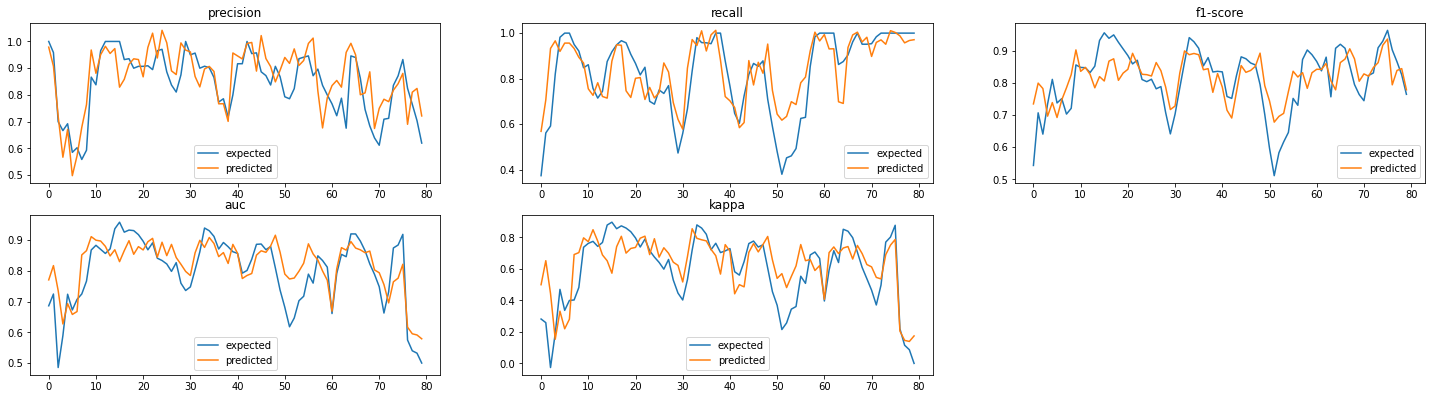

In [9]:
models = {}
fig = plt.figure(figsize=(25, 10))

for idx, metric in enumerate(evaluator.clf_metrics):
    update_params={'meta_label_metric': metric}
    y_true, y_pred = offline_train(update_params, learner, validation_base)
    result = plot_results(y_true, y_pred, title=metric, idx=idx)
    models[metric] = learner.meta_model.model
    
    result = {**result, **{'type': 'meta learning', 'metric': metric}}
    results.append(result)

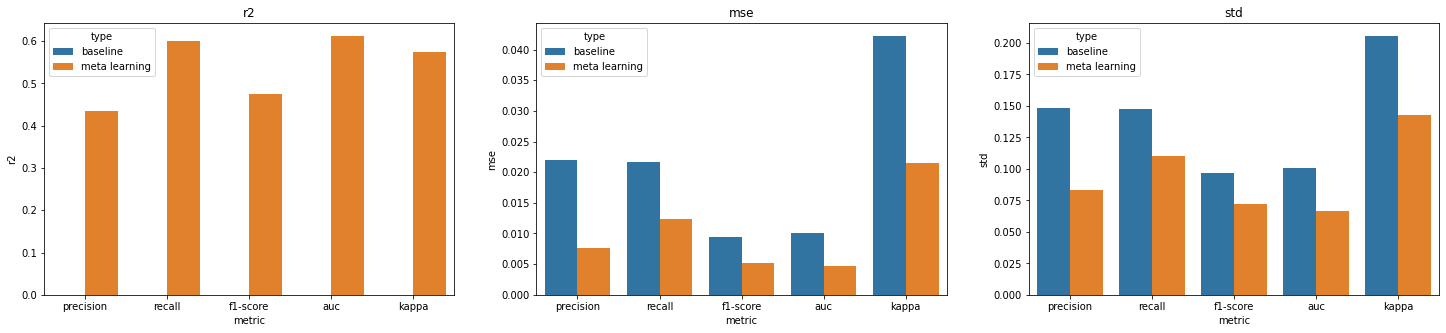

In [10]:
results_metrics = pd.DataFrame(results)
fig = plt.figure(figsize=(25, 5))

for idx, col in enumerate(['r2', 'mse', 'std']):
    plt.subplot(1, 3, idx + 1)
    sns.barplot(x="metric", hue="type", y=col, data=results_metrics)
    plt.title(col)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

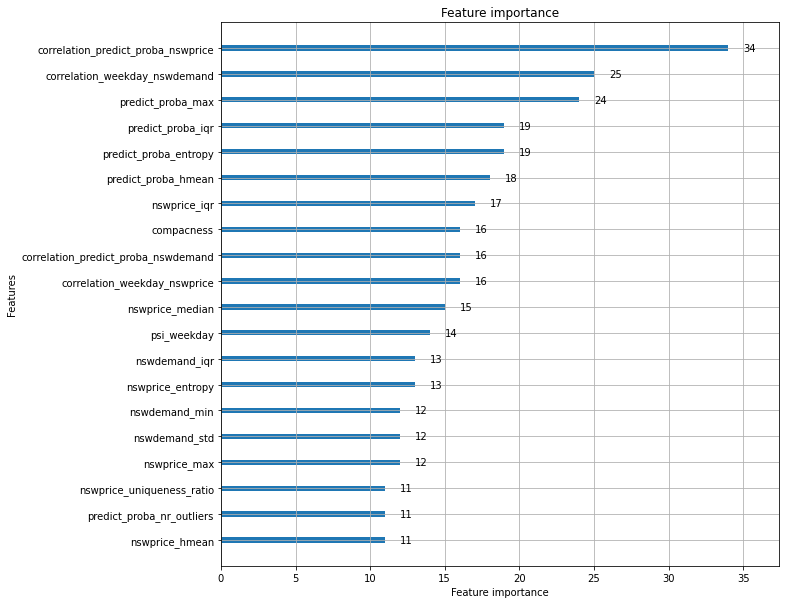

In [11]:
metric = 'precision'
ltb.plot_importance(models[metric], figsize=(10, 10), max_num_features=20)